In [1]:
from IPython import display

# Domestic Perception Functionalities
We will mostly focus on Object Detection, since person recognition is somewhat separated from the other components, and should be refactored to use `mas_perception` architecture.

## Table of contents
* [Overview](#Overview)

## Overview

Previously, object detection in `mcr_scene_segmentation` and the built-in `tabletop_segmentator` on the HSR has the following general structure

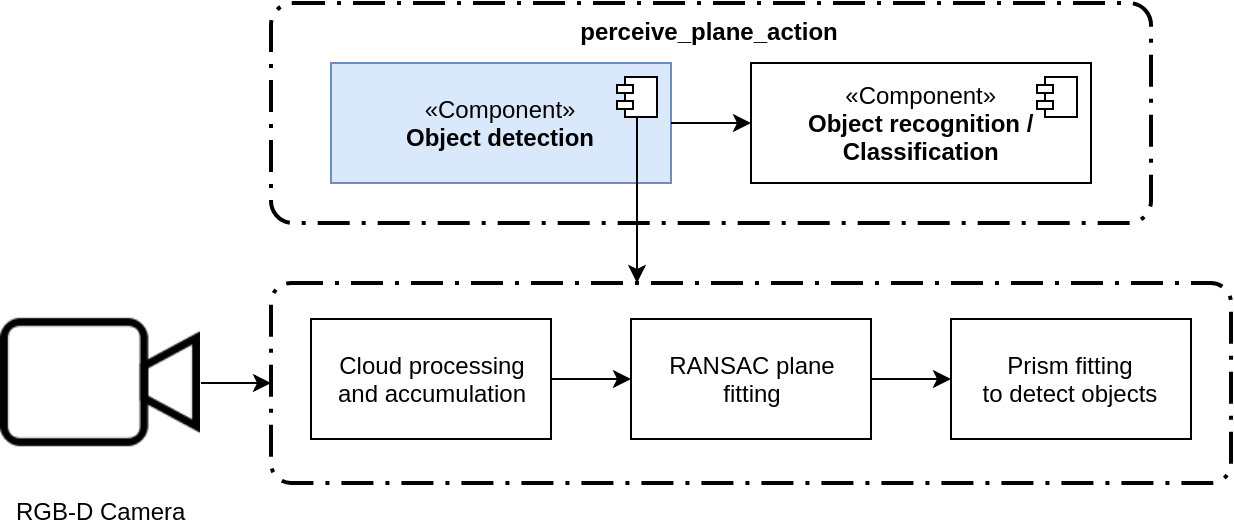

In [2]:
display.Image('images/grasp_pipeline_old_perception.png', width=600)

On the @Home team, object detection has a different architecture

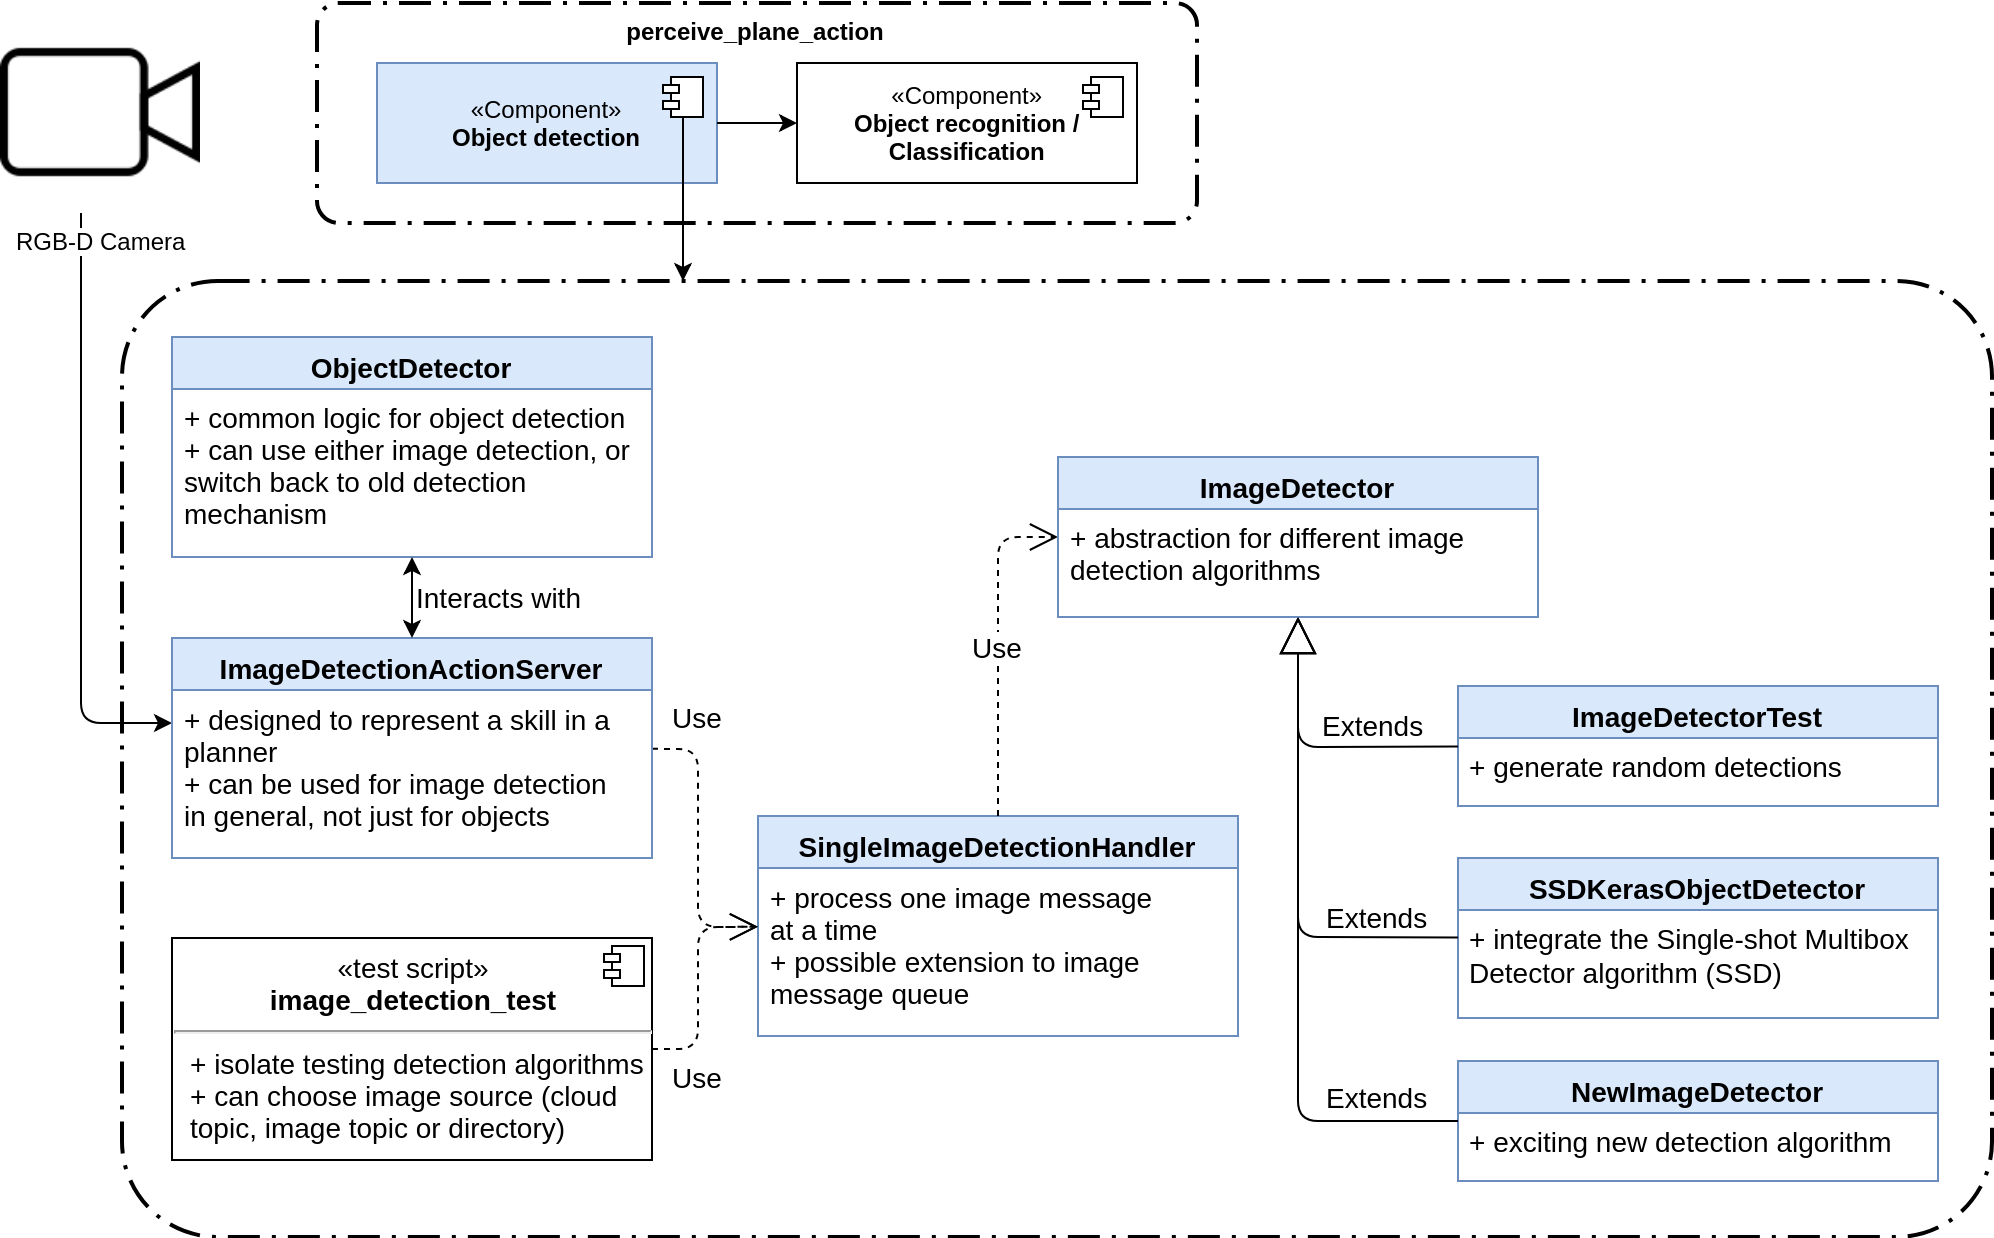

In [3]:
display.Image('images/grasp_pipeline_new_perception.png')